This Notebook is about two preprocess functions. Both find in Covidnet-CT [https://github.com/haydengunraj/COVIDNet-CT/blob/master/data_utils.py]

autocrop: the main ideia is make a automatic crop of the image at the borders of the lung.

exterior extrusion: remove the features in the background while preserve the lung space.

In [1]:
import cv2
import pathlib
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# auto crop images

contours  [[[214 289]]]


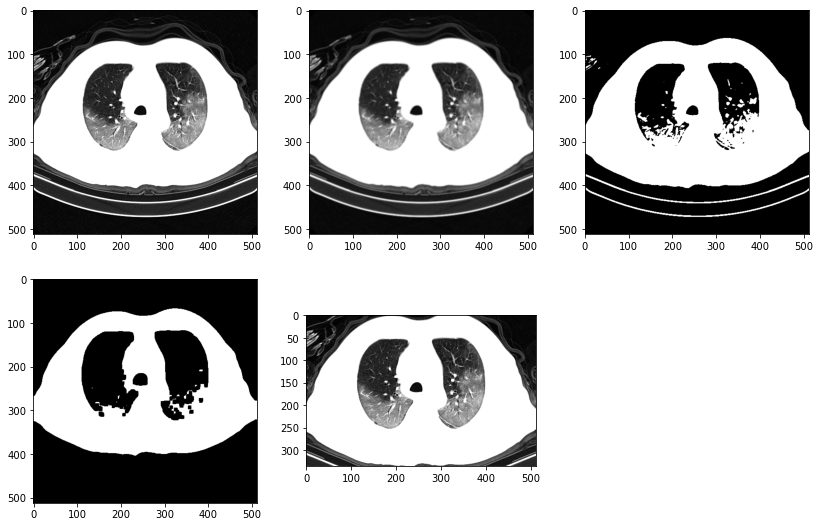

In [22]:
image_file = './NCP_544_2246_0019_middle_lung_test.png'
image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

scale = 1.0

plt.figure(figsize=(14, 14))
plt.subplot(3, 3, 1)
plt.imshow(image, cmap='gray')
filt_image = cv2.GaussianBlur(image, (5, 5), 0)
plt.subplot(3, 3, 2)
plt.imshow(filt_image, cmap='gray')
thresh = cv2.threshold(
    filt_image[filt_image > 0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
bin_image = np.uint8(filt_image > thresh)
plt.subplot(3, 3, 3)
plt.imshow(bin_image, cmap='gray')
erode_kernel = np.ones((7, 7), dtype=np.uint8)
bin_image = cv2.erode(bin_image, erode_kernel)
plt.subplot(3, 3, 4)
plt.imshow(bin_image, cmap='gray')

img, contours, hierarchy = cv2.findContours(
    bin_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
areas = [cv2.contourArea(cnt) for cnt in contours]
body_idx = np.argmax(areas)
body_cont = contours[body_idx].squeeze()

# Get bbox
xmin = body_cont[:, 0].min()
xmax = body_cont[:, 0].max() + 1
ymin = body_cont[:, 1].min()
ymax = body_cont[:, 1].max() + 1

# Scale to final bbox
if scale > 0 and scale != 1.0:
    center = ((xmax + xmin)/2, (ymin + ymax)/2)
    width = scale*(xmax - xmin + 1)
    height = scale*(ymax - ymin + 1)
    xmin = int(center[0] - width/2)
    xmax = int(center[0] + width/2)
    ymin = int(center[1] - height/2)
    ymax = int(center[1] + height/2)

plt.subplot(3, 3, 5)
plt.imshow(image[ymin:ymax, xmin:xmax], cmap='gray')

# exterior exclusion

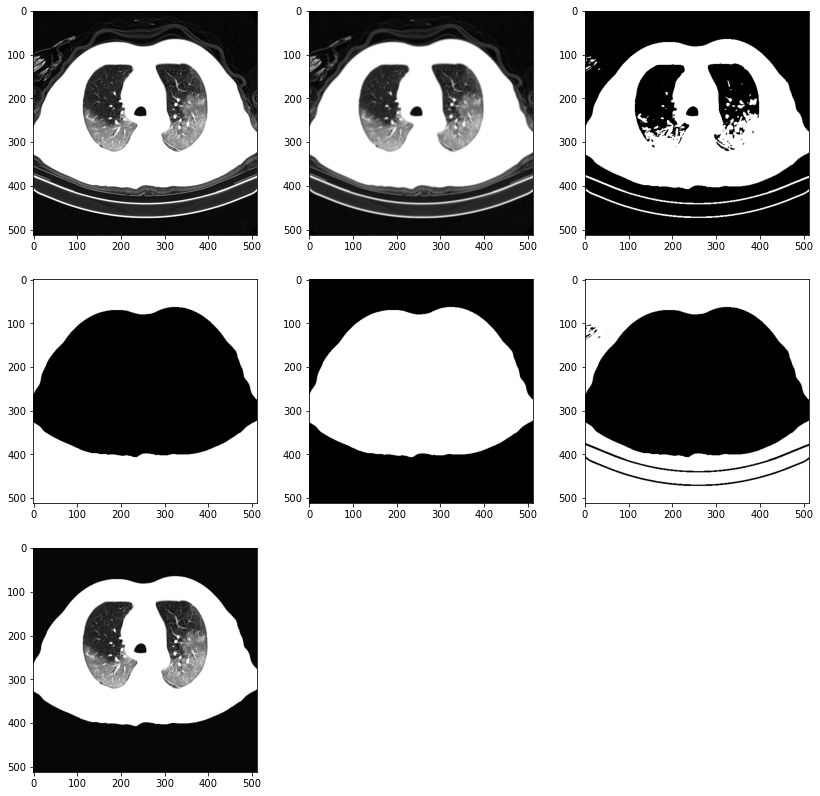

In [28]:
image_file = './NCP_544_2246_0019_middle_lung_test.png'
image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

# Create initial binary image
plt.figure(figsize=(14, 14))
plt.subplot(3, 3, 1)
plt.imshow(image, cmap='gray')
filt_image = cv2.GaussianBlur(image, (5, 5), 0)
plt.subplot(3, 3, 2)
plt.imshow(filt_image, cmap='gray')
thresh = cv2.threshold(
    filt_image[filt_image > 0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
bin_image = np.uint8(filt_image > thresh)
plt.subplot(3, 3, 3)
plt.imshow(bin_image, cmap='gray')

# Find body contour
img, contours, hierarchy = cv2.findContours(bin_image.astype(
    np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
areas = [cv2.contourArea(cnt) for cnt in contours]
body_idx = np.argmax(areas)
body_cont = contours[body_idx].squeeze()

# Exclude external regions by replacing with bg mean
body_mask = np.zeros(image.shape, dtype=np.uint8)
cv2.drawContours(body_mask, [body_cont], 0, 1, -1)
body_mask = body_mask.astype(bool)
plt.subplot(3, 3, 4)
plt.imshow(body_mask, cmap='binary')
bg_mask = (~body_mask) & (image > 0)
plt.subplot(3, 3, 5)
plt.imshow(bg_mask, cmap='binary')
bg_dark = bg_mask & ~bin_image  # exclude bright regions from mean
plt.subplot(3, 3, 6)
plt.imshow(bg_dark, cmap='gray')
bg_mean = np.mean(image[bg_dark])
image[bg_mask] = bg_mean
plt.subplot(3, 3, 7)
plt.imshow(image, cmap='gray')

In [32]:
cv2.__version__

'3.4.2'